# Simple GAN

This is my first attempt at building a GAN. Let's build a [DCGAN](https://arxiv.org/abs/1511.06434) as in the original implementation and gradually remodel it towards using [Wasserstein loss](https://arxiv.org/abs/1701.07875). 
On a side note, how about trying to build something like a motivator which outputs an image *I* as well as the probability *p* that it is real? Can this be fed into the generator to help it converge?

## Imports

In [445]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
import DL_utils.dl as dl; importlib.reload(dl) #  makes sure dl is always reloaded when changed\n",
from DL_utils.dl import * # access all imports of dl"

from tqdm import tqdm

In [2]:
limit_mem()

## Paths

In [3]:
WORKDIR = './'

## Variables

In [4]:
BATCH_SIZE = 128

## Data

For starters why not really use MNIST, then CIFAR-10 and work up from there. Training will be fast and we can see if it is working.

In [5]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

In [6]:
n = len(X_train)

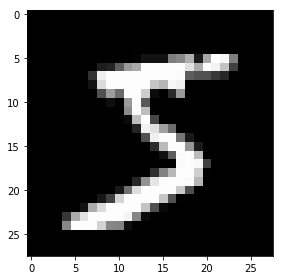

In [7]:
io.imshow(X_train[0])

In [8]:
X_train = X_train/255.
X_test = X_test/255.

In [9]:
X_train = X_train.reshape(n, 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

In [10]:
print(np.max(X_train))
print(X_train.shape)

1.0
(60000, 28, 28, 1)


In [11]:
size = X_train[0].shape; print(size)

(28, 28, 1)


Random Noise generator

In [12]:
def noise(bs): return np.random.rand(bs,100)

In [13]:
noise(10).shape

(10, 100)

## Rebuilding WGAN in Keras

### Build models

#### Generator

This is a version of the generator used in Jeremy's WGAN.ipynb translated to Keras. Note: some UpSampBlocks are commented out, because the MNIST pictures are only 28x28 pixels. I experimented with different architectures and left them in for study purposes. I pointed out which ones were the most successful ones.  

In [418]:
K.clear_session()

In [93]:
def UpSampBlock(input_tensor, repeats, filters, kernel_size, stride):
    x = UpSampling2D(size=stride)(input_tensor)
    x = Convolution2D(filters, kernel_size[0], kernel_size[1], subsample=(1,1), border_mode='same')(x)
    x = BatchNormalization(epsilon=1e-5, momentum=0.1, axis=-1, mode=2)(x)
    return Activation('relu')(x)    

inp = Input(shape=(100,))
x = Dense(512*7*7, activation=LeakyReLU())(inp)
x = BatchNormalization(mode=2)(x)
x = Reshape((7, 7, 512))(x)
x = UpSampBlock(input_tensor=x, repeats=1, filters=512, kernel_size=(4, 4), stride=(1, 1))
x = UpSampBlock(x, 1, 256, (4, 4), (2, 2))
#x = UpSampBlock(x, 1, 128, (4, 4), (2, 2))  # With MNIST they are becoming too big
#x = UpSampBlock(x, 1, 64, (4, 4), (2, 2))
#x = UpSampBlock(x, 1, 64, (3, 3), (1, 1))
x = UpSampling2D(size=(2,2))(x)
x = Convolution2D(1, 3, 3, subsample=(1,1), border_mode='same')(x)
x = Activation('tanh')(x)
#x = Convolution2D(1, 4, 4, subsample=(1, 1), bias=False)(x)
net_G = Model([inp], [x])
net_G.compile(optimizer=RMSprop(1e-4), loss='binary_crossentropy')

Alternative simpler architecture:

In [369]:
def UpSampBlock(input_tensor, repeats, filters, kernel_size, stride):
    x = UpSampling2D(size=stride)(input_tensor)
    x = Convolution2D(filters, kernel_size[0], kernel_size[1], subsample=(1,1), border_mode='same')(x)
    x = BatchNormalization(epsilon=1e-5, momentum=0.1, axis=-1, mode=2)(x)
    return Activation('relu')(x)    

inp = Input(shape=(100,))
x = Dense(512*7*7)(inp)
x = Reshape((7, 7, 512))(x)
x = BatchNormalization(mode=2, axis=-1)(x)
x = Activation('relu')(x)
#x = UpSampBlock(input_tensor=x, repeats=1, filters=512, kernel_size=(4, 4), stride=(1, 1))
x = UpSampBlock(x, 1, 64, (4, 4), (2, 2))
x = UpSampling2D(size=(2,2))(x)
x = Convolution2D(1, 3, 3, border_mode='same', activation='tanh')(x)
net_G = Model([inp], [x])
net_G.compile(optimizer=RMSprop(1e-4), loss='mse')

The following has been the most successful generator so far.

In [441]:
net_G = Sequential([
    Dense(512*7*7, input_dim=100),
    LeakyReLU(),
    BatchNormalization(mode=2, axis=-1),
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Convolution2D(64, 3, 3, border_mode='same'),
    BatchNormalization(mode=2, axis=-1),
    LeakyReLU(), # Some implementations use ReLU instead
    UpSampling2D(),
    Convolution2D(32, 3, 3, border_mode='same'),
    BatchNormalization(mode=2, axis=-1),
    LeakyReLU(), # Some implementations use ReLU instead
    Convolution2D(1, 1, 1, border_mode='same', activation='sigmoid')
])
net_G.compile(optimizer=RMSprop(1e-4), loss='binary_crossentropy')

In [442]:
net_G.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_2 (Dense)                  (None, 25088)         2533888     dense_input_2[0][0]              
____________________________________________________________________________________________________
leakyrelu_6 (LeakyReLU)          (None, 25088)         0           dense_2[0][0]                    
____________________________________________________________________________________________________
batchnormalization_6 (BatchNorma (None, 25088)         100352      leakyrelu_6[0][0]                
____________________________________________________________________________________________________
reshape_2 (Reshape)              (None, 7, 7, 512)     0           batchnormalization_6[0][0]       
___________________________________________________________________________________________

#### Discriminator

The discriminator is a tranlated version from WGAN.ipynb to Keras. It uses the parameter *clipvalue* for the optimizer, as required by the Wasserstein paper. 

Here is the famous Wasserstein loss:

In [284]:
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [338]:
clip_norm = keras.constraints.MinMaxNorm(low=-0.01, high=0.01, rate=1.0, axis=1)

def ConvBlock(input_tensor, repeats, filters, kernel_size, stride, clip=None):
    for i in range(repeats):
        x = ZeroPadding2D((1, 1))(input_tensor)
        x = Convolution2D(filters, kernel_size[0], kernel_size[1], subsample=stride, bias=False, border_mode='same', W_constraint=clip)(x)
        x = BatchNormalization(epsilon=1e-5, momentum=0.1, axis=-1, mode=2)(x)
        x = LeakyReLU(alpha=0.2)(x)
        #print(x)
    return x

inp = Input(shape=size)
x = ConvBlock(input_tensor=inp, repeats=1, filters=64, kernel_size=(4, 4), stride=(2, 2), clip=clip_norm)
x = ConvBlock(x, 1, 64, (3, 3), (1, 1), clip_norm)
x = ConvBlock(x, 1, 128, (4, 4), (2, 2), clip_norm)
x = ConvBlock(x, 1, 256, (4, 4), (2, 2), clip_norm)
x = ConvBlock(x, 1, 512, (4, 4), (2, 2), clip_norm)
#x = Convolution2D(1, 4, 4, subsample=(1, 1), bias=False)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation = 'sigmoid')(x)
net_D = Model([inp], [x])
net_D.compile(optimizer=RMSprop(1e-3), loss='mse') 

In [339]:
net_D.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
zeropadding2d_3 (ZeroPadding2D)  (None, 30, 30, 1)     0           input_2[0][0]                    
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 15, 15, 64)    1024        zeropadding2d_3[0][0]            
____________________________________________________________________________________________________
batchnormalization_5 (BatchNorma (None, 15, 15, 64)    256         convolution2d_5[0][0]            
___________________________________________________________________________________________

I used some code from [tdeboissere](https://github.com/tdeboissiere/DeepLearningImplementations) for this function. It allows you to add the correct number of conv layers depending on image size automatically. 

In [421]:
def discriminator(img_dim, model_name="discriminator", clipping=True):
    """DCGAN discriminator
    Args:
        img_dim: dimension of the image output
        model_name: model name (default: {"discriminator"})
    Returns:
        keras model
    """
    
    bn_mode = 2

    # Tensorflow only
    bn_axis = -1
    min_s = min(img_dim[:-1])
    
    if clipping:
        clip_norm = keras.constraints.MinMaxNorm(low=-0.01, high=0.01, rate=1.0, axis=1)
    else:
        clip_norm = None
    
    def ConvBlock(input_tensor, repeats, filters, kernel_size, stride, clip=None):
        for i in range(repeats):
            x = ZeroPadding2D((1, 1))(input_tensor)
            x = Convolution2D(filters, kernel_size[0], kernel_size[1], subsample=stride, 
                              bias=False, border_mode='same', W_constraint=clip)(x)
            x = BatchNormalization(epsilon=1e-5, momentum=0.1, axis=bn_axis, mode=bn_mode)(x)
            x = LeakyReLU(alpha=0.2)(x)
            #print(x)
        return x

    inp = Input(shape=img_dim, name="discriminator_input")
    # Get the list of number of conv filters
    # (first layer starts with 64), filters are subsequently doubled
    nb_conv = int(np.floor(np.log(min_s // 4) / np.log(2)))
    list_f = [64 * min(8, (2 ** i)) for i in range(nb_conv)]
    # First conv with 2x2 strides
    
    x = ConvBlock(input_tensor=inp, repeats=1, filters=list_f[0], 
                  kernel_size=(4, 4), stride=(2, 2), clip=clip_norm)

    # Conv blocks: Conv2D(2x2 strides)->BN->LReLU
    for i, f in enumerate(list_f[1:]):
        x = ConvBlock(input_tensor=x, repeats=1, filters=f, 
              kernel_size=(4, 4), stride=(2, 2), clip=clip_norm)


    # Last convolution
    x = Convolution2D(1, 3, 3, name="last_conv", border_mode="same", bias=False)(x)
    # Average pooling
    x = GlobalAveragePooling2D()(x)

    discriminator_model = Model(input=[inp], output=[x], name=model_name)

    return discriminator_model

This is probably the most successful discriminator so far:

In [422]:
net_D = discriminator(size, clipping=False)
net_D.compile(optimizer=RMSprop(1e-3), loss=wasserstein) 
net_D.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
discriminator_input (InputLayer) (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 30, 30, 1)     0           discriminator_input[0][0]        
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 15, 15, 64)    1024        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_4 (BatchNorma (None, 15, 15, 64)    256         convolution2d_4[0][0]            
___________________________________________________________________________________________

In [208]:
clip_norm = keras.constraints.MinMaxNorm(low=-0.01, high=0.01, rate=1.0, axis=1)
net_D = Sequential([
    Conv2D(256, 5, 5, subsample=(2,2), border_mode='same', 
                  input_shape=(28, 28, 1), W_constraint=clip_norm),
    BatchNormalization(epsilon=1e-5, momentum=0.1, axis=-1), 
    LeakyReLU(alpha=0.2),
    Conv2D(512, 5, 5, subsample=(2,2), border_mode='same', W_constraint=clip_norm),
    BatchNormalization(epsilon=1e-5, momentum=0.1, axis=-1), 
    LeakyReLU(alpha=0.2),
    Flatten(),
    Dense(256, W_constraint=clip_norm),
    LeakyReLU(),
    Dense(1, activation = 'sigmoid')
])

net_D.compile(RMSprop(1e-3), "mse") #, clipvalue=0.01


In [337]:
net_D.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
discriminator_input (InputLayer) (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 30, 30, 1)     0           discriminator_input[0][0]        
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 15, 15, 64)    1024        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 15, 15, 64)    256         convolution2d_3[0][0]            
___________________________________________________________________________________________

This is one step of optimization with half real images (X_train) and half fake ones (net_G.predict). 

In [305]:
def data_D(nb_samples, G):
    real_img = X_train[np.random.randint(0,n,size=nb_samples)]
    X = np.concatenate((real_img, G.predict(noise(nb_samples))))
    return X, [-1]*nb_samples + [1]*nb_samples # D needs to maximize loss on real data, hence -1

In [372]:
def real_data_D(nb_samples):
    X = X_train[np.random.randint(0,n,size=nb_samples)]
    return X, [-1]*nb_samples

In [373]:
def fake_data_D(nb_samples, G):
    X = G.predict(noise(nb_samples))
    return X, [1]*nb_samples

In [265]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers: l.trainable = val

This weight clipping regime was originally used by tdeboissere (see above). At first I thought it was going to make training slow, because it is useing CPU/RAM, not GPU. But it doesn't seem to hurt the performance in practice. The second version below is my (buggy) attempt at implementing it in the GPU using keras. Please feel free to fix it and send a PR ;-) 

In [374]:
def clip_weights(net, clipvalue):
    for l in net.layers:
        weights = l.get_weights()
        weights = [np.clip(w, -1*clipvalue, clipvalue) for w in weights]
        l.set_weights(weights)    

In [59]:
def clip_weights(net, clipvalue):
    for l in net.layers:
        weights = K.variable(l.get_weights())
        weights = [K.clip(w, -1*clipvalue, clipvalue) for w in weights]
        l.set_weights(weights)    


This is the translated version of train from WGAN.ipynb to Keras.

In [423]:
# D discriminator
# G generator
# m GAN model
# bs = number of batches per epoch
# np_epoch: Number of epochs
def train_WGAN(D, G, m, nb_epoch=5000, bs=128, first=True):
    dl,gl,rl,fl=[],[],[],[] 
    gen_iterations = 0 # Counter for generator training iterations
    #progbar = generic_utils.Progbar(nb_epoch)
    
    for e in tqdm(range(nb_epoch)):
        i = 0 # batch counter
        while i < bs: 
            make_trainable(D, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)
            j = 0
            while j < d_iters and i < bs:
                #print('d_iter {}, epoch {}'.format(j,i))
                j += 1; i += 1
                #X,y = data_D(bs//2, G)
                clip_weights(D, 0.5)
                #dl.append(D.train_on_batch(X,y))
                X,y = real_data_D(bs//2)
                rl.append(D.train_on_batch(X,y))
                X,y = fake_data_D(bs//2, G)
                fl.append(D.train_on_batch(X,y))
                dl.append(np.mean([-rl[-1], fl[-1]]))

                
            make_trainable(D, False)
            # G needs to maximize loss, hence negative sign
            gl.append(m.train_on_batch(noise(bs), -np.ones([bs]))) 
            gen_iterations+=1
            #gl.append(G.train_on_batch(noise(bs), X))
            #progbar.add(bs, values=[("Loss_D", np.mean(dl)), ("Loss_G", -gl)])
                                #("Loss_D_real", -np.mean(list_disc_loss_real)),
                                #("Loss_D_gen", np.mean(list_disc_loss_gen)),

    
    return dl,gl,rl,fl

In [449]:
m_WGAN = Sequential([net_G, net_D])
m_WGAN.compile(RMSprop(5e-5), loss=wasserstein) #, clipvalue=0.01

### Larger experiment training both, D and G

In [427]:
K.set_value(net_D.optimizer.lr, 5e-5)
K.set_value(m_WGAN.optimizer.lr, 5e-5)

In [428]:
dl,gl,rl,fl = train_WGAN(net_D, net_G, m_WGAN, 5000)

100%|██████████| 5000/5000 [6:27:39<00:00,  4.61s/it]  


In [446]:
save_model(net_G, WORKDIR+'results/SimpleGAN_G', 'first_successful_run')

2017-03-21-09:46
first_successful_run
Saved  model  to  disk


In [447]:
save_model(net_D, WORKDIR+'results/SimpleGAN_D', 'first_successful_run')

2017-03-21-09:46
first_successful_run
Saved  model  to  disk


In [450]:
save_model(m_WGAN, WORKDIR+'results/WGAN', 'first_successful_run')

2017-03-21-09:46
first_successful_run
Saved  model  to  disk


In [429]:
net_D.predict(X_train[:10])

array([[ 235.74121094],
       [ 236.91166687],
       [ 235.07270813],
       [ 234.50408936],
       [ 235.76533508],
       [ 236.58557129],
       [ 234.92675781],
       [ 236.67329407],
       [ 233.59443665],
       [ 235.26185608]], dtype=float32)

In [430]:
net_D.predict(net_G.predict(noise(10)))

array([[ 235.77381897],
       [ 237.08248901],
       [ 234.50561523],
       [ 234.04719543],
       [ 235.15248108],
       [ 237.56547546],
       [ 236.52388   ],
       [ 234.82521057],
       [ 235.44361877],
       [ 234.20721436]], dtype=float32)

In [431]:
fig, ax = plt.subplots()
ax.plot(dl, label='Mean discriminator loss')
ax.plot(rl, label='D loss on real data')
ax.plot(fl, label='D loss on fake data')
ax.legend()

In [432]:
plt.plot(gl, label='Generator loss')
plt.legend()

Note: Ignore the error message below. It worked the first time. 

In [452]:
nb_eg = 12
fakenumbers = net_G.predict(noise(nb_eg)).reshape(nb_eg, 28,28)

TypeError: 'module' object is not callable

In [434]:
print(fakenumbers.shape)

(12, 28, 28)


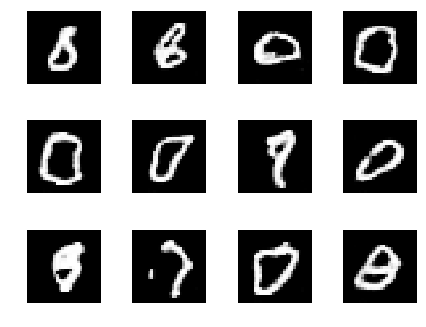

In [435]:
plot_multi(fakenumbers, figsize=(6., 6.), cmap='gray')